# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/19yU_e179LvCwu_me09V5rCA-WMwa4r-D?usp=sharing

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

100%|██████████| 170498071/170498071 [00:02<00:00, 61676333.37it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

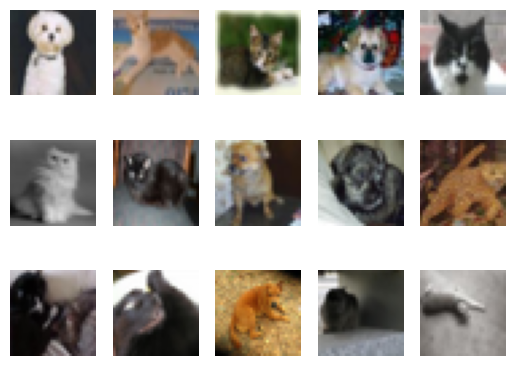

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [ ]:
print("number of training:", len(train_loader))
print("number of validation:", len(val_loader))
print("number of test:", len(test_loader))

number of training: 8000
number of validation: 2000
number of test: 2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

We need the validation set because we want a set of examples to tune the program's hyperparameters. We use the validation set to find the appropriate pause point for the backpropagation process. If we judge the performance of our models using the training set loss/error instead of the validation set ones, we could create an overfitted model with biases and a too-optimistic error rate estimation.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
small = 0
large= 0

for param in small_net.parameters():
    small += param.numel()

for param in large_net.parameters():
    large += param.numel()

print("The number of small parameters is", small)
print("The number of large parameters is", large)

The number of small parameters is 386
The number of large parameters is 9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)


    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

The default values are batch_size=64, learning_rate=0.01, and num_epochs=30.  

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

five disk file that saves the version of the neural network that was developed per epoch:

*   model_small_bs64_lr0.01_epoch0
*   model_small_bs64_lr0.01_epoch1
*   model_small_bs64_lr0.01_epoch2
*   model_small_bs64_lr0.01_epoch3
*   model_small_bs64_lr0.01_epoch4


These files contain the values on the train error/values and validation error/loss values at epoch 4 as .csv file:

*   model_small_bs64_lr0.01_epoch4_train_err.csv
*   model_small_bs64_lr0.01_epoch4_train_loss.csv
*   model_small_bs64_lr0.01_epoch4_val_err.csv
*   model_small_bs64_lr0.01_epoch4_val_loss.csv

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# small_net train
train_net(small_net,64,0.01,30)

# large_net train
train_net(large_net,64,0.01,30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.42275, Train loss: 0.673784264087677 |Validation err: 0.378, Validation loss: 0.6565281003713608
Epoch 2: Train err: 0.37, Train loss: 0.6458141713142395 |Validation err: 0.371, Validation loss: 0.652947960421443
Epoch 3: Train err: 0.3495, Train loss: 0.6265174641609191 |Validation err: 0.3465, Validation loss: 0.6212373971939087
Epoch 4: Train err: 0.3325, Train loss: 0.6074911532402039 |Validation err: 0.36, Validation loss: 0.6289773602038622
Epoch 5: Train err: 0.323125, Train loss: 0.5964790120124817 |Validation err: 0.333, Validation loss: 0.6159699466079473
Epoch 6: Train err: 0.31325, Train loss: 0.5861919419765472 |Validation err: 0.3325, Validation loss: 0.613245127722621
Epoch 7: Train err: 0.308625, Train loss: 0.5836091318130493 |Validation err: 0.327, Validation loss: 0.6075554452836514
Epoch 8: Train err: 0.303, Train loss: 0.5773005082607269 |Validation err: 0.324, Validat



*   Large: 145.72 seconds
*   small: 132.75 seconds


The large_net takes longer to train because it has more parameters (9705) than the small_net parameters (386) proven in part 2 (a). Thus, there are more computes and updates, resulting in the time increase.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

small_net training curve


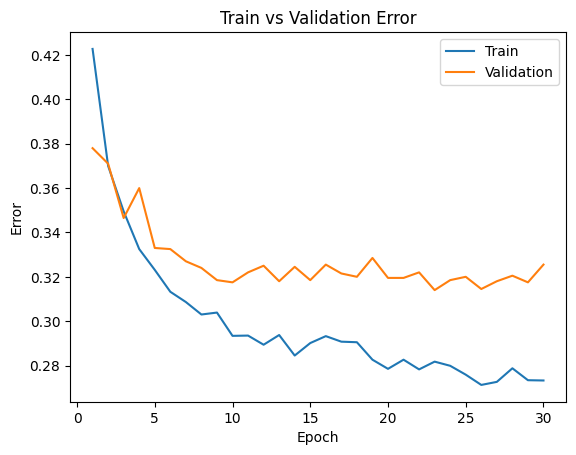

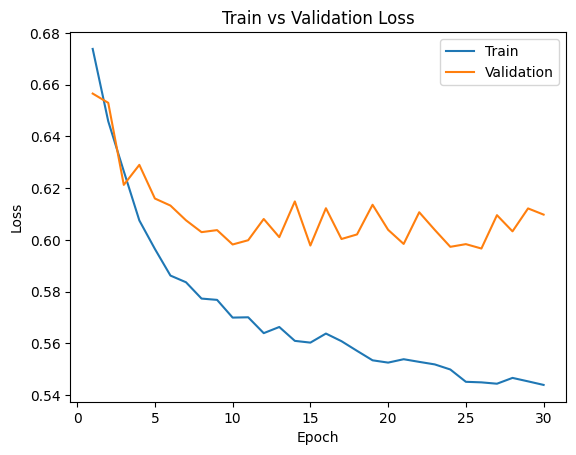

In [ ]:
small_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
large_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)

print("small_net training curve")
plot_training_curve(small_path)

large_net training curve


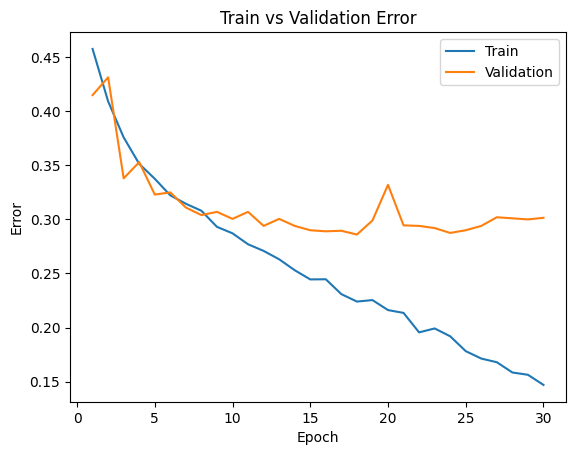

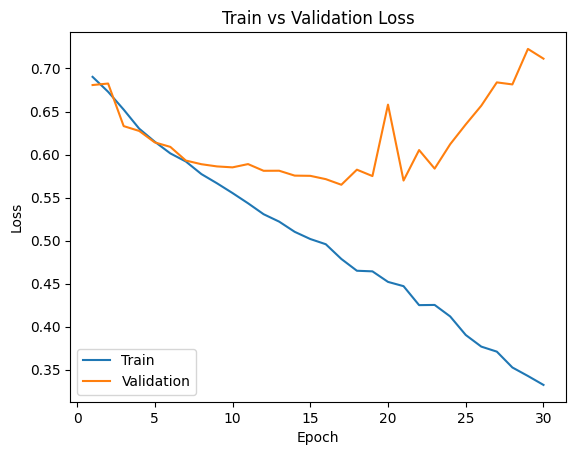

In [ ]:
print("large_net training curve")
plot_training_curve(large_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

small_net curve: For the small_net learning curve, the training loss is slightly decreasing while the validation loss is fluctuating without a clear decreasing trend. This shows that the model is not learning the data pattern and underfitting the validation dataset.


large_net curve: For the large_net learning curve, the graph presents a clear downward trend for both training data and validation data at epoch 0-10. This shows that this model is underfitting at the beginning. However, after that, although training loss/error is still decreasing at approximately a similar roughly linear rate, the validation loss/error stops decreasing along. The error remains somewhat constant, and the loss instead increases starting around epoch 15, indicating overfitting of the model.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate=0.001)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360004425049 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589740753173 |Validation err: 0.4305, Validation loss: 0.6916493494063616
Epoch 3: Train err: 0.43575, Train loss: 0.6916067256927491 |Validation err: 0.4285, Validation loss: 0.6908544301986694
Epoch 4: Train err: 0.43, Train loss: 0.6908613419532776 |Validation err: 0.424, Validation loss: 0.6896595824509859
Epoch 5: Train err: 0.434125, Train loss: 0.6899194955825806 |Validation err: 0.4195, Validation loss: 0.6886935662478209
Epoch 6: Train err: 0.43575, Train loss: 0.688741192817688 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774199485779 |Validation err: 0.4185, Validation loss: 0.6851983051747084
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.41

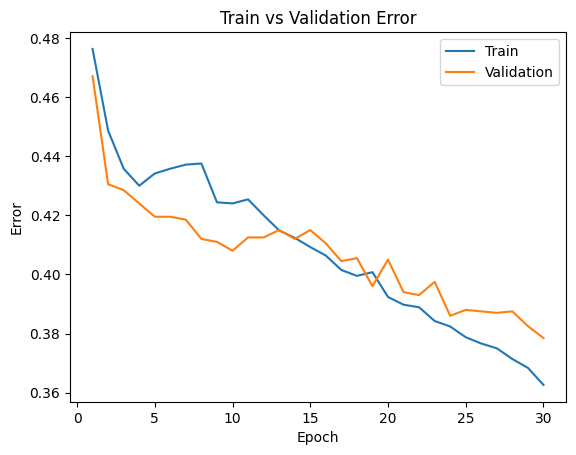

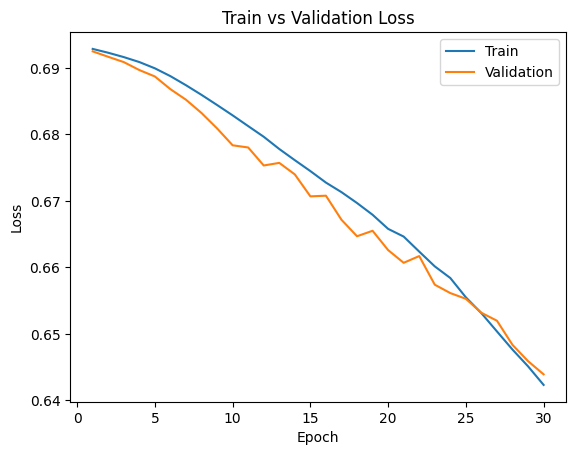

In [ ]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

The eplased time is 149.88, thus takes around the same time (slightly more) to train.

Lowering the learning rate slows down the training progress, making small updates to the weights in the networks to gain a more precise parameter updates while taking a longer time. The model get higher error and higher loss in
training data. For validation, the error is higher, but the loss shows
overfitting is avoided. 0.001 is too slow.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [ ]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.1)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.6743778004646301 |Validation err: 0.3595, Validation loss: 0.6350856963545084
Epoch 2: Train err: 0.36075, Train loss: 0.6411805462837219 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813464164734 |Validation err: 0.3385, Validation loss: 0.6056603863835335
Epoch 4: Train err: 0.352625, Train loss: 0.623345623254776 |Validation err: 0.3575, Validation loss: 0.6362800160422921
Epoch 5: Train err: 0.34075, Train loss: 0.610801386833191 |Validation err: 0.3305, Validation loss: 0.6064918749034405
Epoch 6: Train err: 0.323375, Train loss: 0.5921835992336273 |Validation err: 0.317, Validation loss: 0.5967769687995315
Epoch 7: Train err: 0.3145, Train loss: 0.5817317562103271 |Validation err: 0.3365, Validation loss: 0.6204487904906273
Epoch 8: Train err: 0.29825, Train loss: 0.5660300071239471 |Validation err: 0.

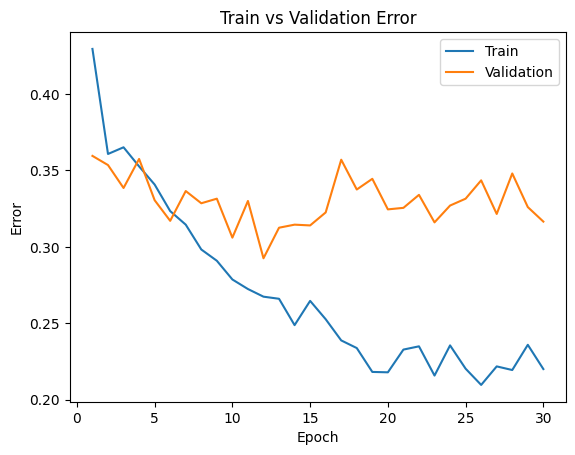

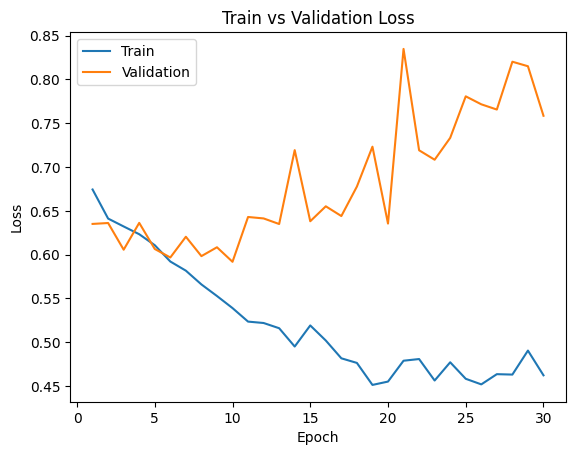

In [ ]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path)

The eplased time is 162.05, thus takes slightly longer to train.

The learning rate being too high creates noise and is detrimental to the training. It is "jumping" to suboptimal set of biases and weights as the optimal values are missed due to the large learning rate. Increasing the learning rate makes the model get higher error and higher loss in
training and validation data. Also, the error and loss shows overfitting. 0.1 is too fast.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

In [ ]:
large_net = LargeNet()
train_net(large_net,batch_size=512)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104057252407 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500627994537 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449903130531 |Validation err: 0.424, Validation loss: 0.6897870302200317
Epoch 5: Train err: 0.434, Train loss: 0.6896935515105724 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.6883532106876373 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871751844883 |Validation err: 0.426, Validation loss: 0.6836968660354614
Epoch 8: Train err: 0.43525, Train loss: 0.6849770732223988 |Validation err: 0.4115, V

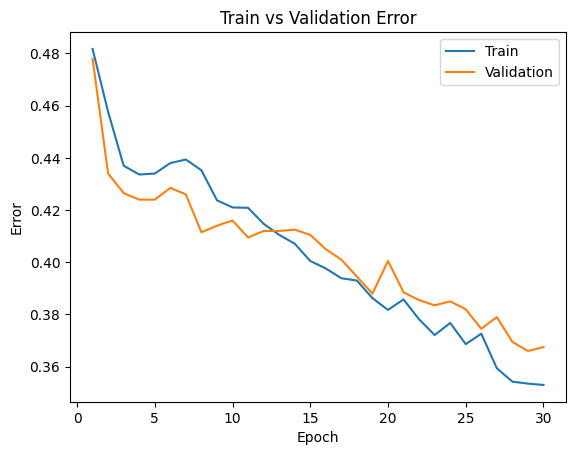

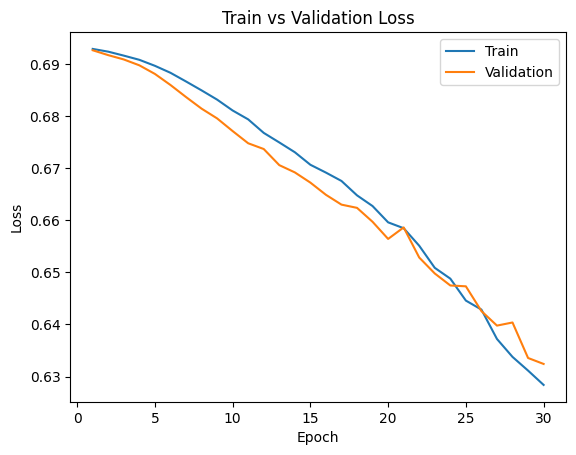

In [ ]:
model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

The eplased time is 132.86, thus takes shorter to train.

The model needs to do less passes to cover the entire training set as it considers more data each time. Therefore, it calculates the gradients and updates weights less times. Increasing the batch size makes the model get higher error and higher loss in training data. In validation, the error and loss are around the same, but the new loss shows no sign of overfitting

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

In [ ]:
large_net = LargeNet()
train_net(large_net,batch_size=16)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994033575058 |Validation err: 0.382, Validation loss: 0.6513170146942139
Epoch 2: Train err: 0.369, Train loss: 0.6396398993134499 |Validation err: 0.3465, Validation loss: 0.6161113579273224
Epoch 3: Train err: 0.34375, Train loss: 0.6098222960829734 |Validation err: 0.3325, Validation loss: 0.6260210766792297
Epoch 4: Train err: 0.314375, Train loss: 0.584969149172306 |Validation err: 0.34, Validation loss: 0.6044013905525207
Epoch 5: Train err: 0.301125, Train loss: 0.5689119317531586 |Validation err: 0.3125, Validation loss: 0.5769183149337769
Epoch 6: Train err: 0.281, Train loss: 0.5452213580608368 |Validation err: 0.308, Validation loss: 0.570844743013382
Epoch 7: Train err: 0.270875, Train loss: 0.5272981309890747 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.507090549826622 |Validation err: 0.313, V

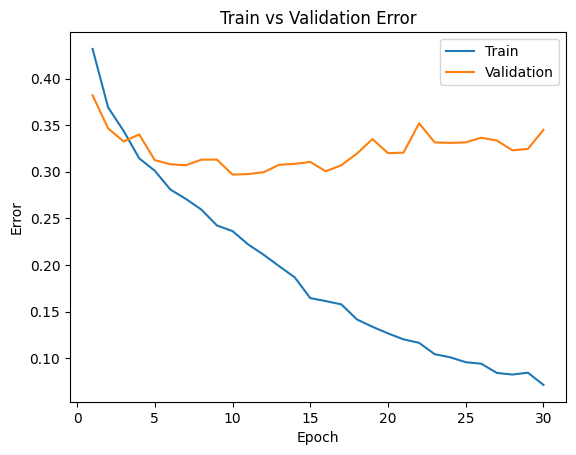

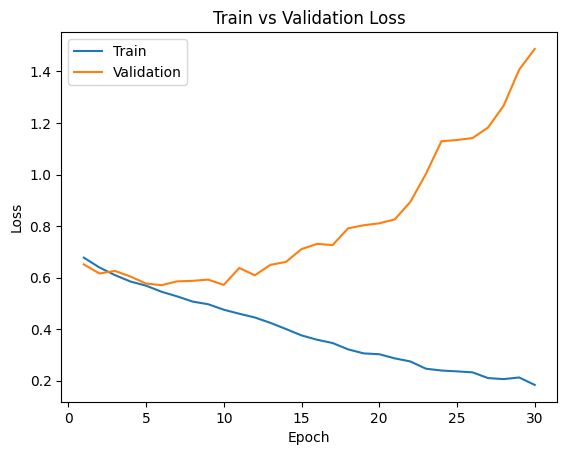

In [ ]:
model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

The eplased time is 228.17, thus takes much longer to train. Because the batch_size decreases, so inside each epoch, the times of iteration is larger, which will take more time.

Having a small batch size introduced too much 'noises' in the training process, causing the training loss significantly diverges with the validation loss. Decreasing the batch size makes the model get lower error and lower loss in training data. But in validation, it is an extremely overfitted model that is unable to perform well on new data.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

I choose network = large_net, batch_size = 128, learning_rate = 0.01, and epoch = 30.
Proven above, large net works better than small net. From part3, 0.01 is a good learning rate, it does not cause a too small or too large "jump".
When batch_size is small, the model would get overfitting, when batch_size increases not by a lot, the peformance is better and does not overfit.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

In [ ]:
large_net = LargeNet()
train_net(large_net,learning_rate=0.01,batch_size=128, num_epochs = 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47025, Train loss: 0.6915813807457213 |Validation err: 0.4435, Validation loss: 0.6885984316468239
Epoch 2: Train err: 0.441625, Train loss: 0.685759805497669 |Validation err: 0.4165, Validation loss: 0.6805880069732666
Epoch 3: Train err: 0.4295, Train loss: 0.6784176694022285 |Validation err: 0.413, Validation loss: 0.6713756285607815
Epoch 4: Train err: 0.41875, Train loss: 0.6712553614661807 |Validation err: 0.3955, Validation loss: 0.6606401465833187
Epoch 5: Train err: 0.393125, Train loss: 0.6617401554470971 |Validation err: 0.371, Validation loss: 0.6519135050475597
Epoch 6: Train err: 0.380625, Train loss: 0.6486233908032614 |Validation err: 0.352, Validation loss: 0.6411975361406803
Epoch 7: Train err: 0.369, Train loss: 0.6427794562445747 |Validation err: 0.3575, Validation loss: 0.6333399601280689
Epoch 8: Train err: 0.35525, Train loss: 0.632211811012692 |Validation err: 0.369

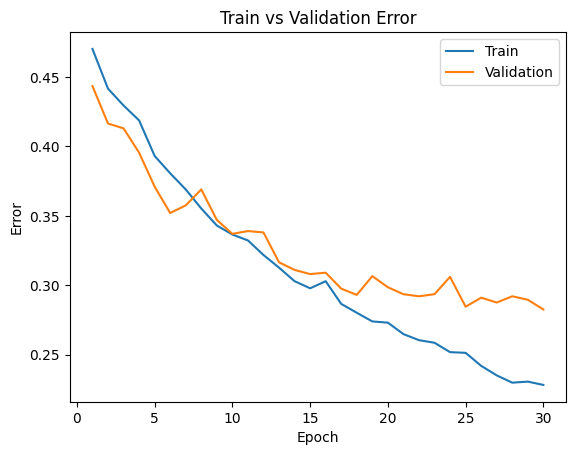

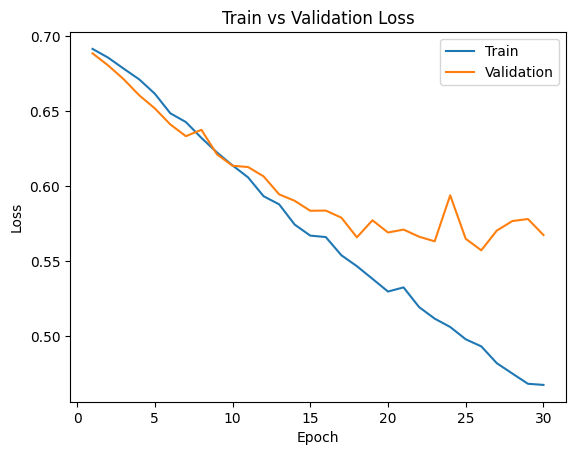

In [ ]:
model_path = get_model_name("large", batch_size=128, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

I choose network = large_net, batch_size = 128, learning_rate = 0.007, and epoch = 25.
Proven above, large net works better than small net.
in part(b)'s training, in epoch 20 to 25, the error and loss are "converging",
and since I decreased the learning_rate a little bit, the model would fits best in epoch slightly larger in the range. So I choose epoch = 25 to get a better model.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [ ]:
large_net = LargeNet()
train_net(large_net,learning_rate=0.007,batch_size=128, num_epochs = 25)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.456625, Train loss: 0.6923577302978152 |Validation err: 0.4225, Validation loss: 0.6909653209149837
Epoch 2: Train err: 0.44975, Train loss: 0.6899599792465331 |Validation err: 0.422, Validation loss: 0.6863732673227787
Epoch 3: Train err: 0.430125, Train loss: 0.685693173181443 |Validation err: 0.412, Validation loss: 0.6801545657217503
Epoch 4: Train err: 0.424125, Train loss: 0.6803461994443621 |Validation err: 0.411, Validation loss: 0.6731148324906826
Epoch 5: Train err: 0.41425, Train loss: 0.6752496891551547 |Validation err: 0.411, Validation loss: 0.6691230684518814
Epoch 6: Train err: 0.40275, Train loss: 0.6695615696528602 |Validation err: 0.396, Validation loss: 0.6658721268177032
Epoch 7: Train err: 0.391375, Train loss: 0.6636068877719697 |Validation err: 0.3935, Validation loss: 0.657893992960453
Epoch 8: Train err: 0.385875, Train loss: 0.6574361522992452 |Validation err: 0.

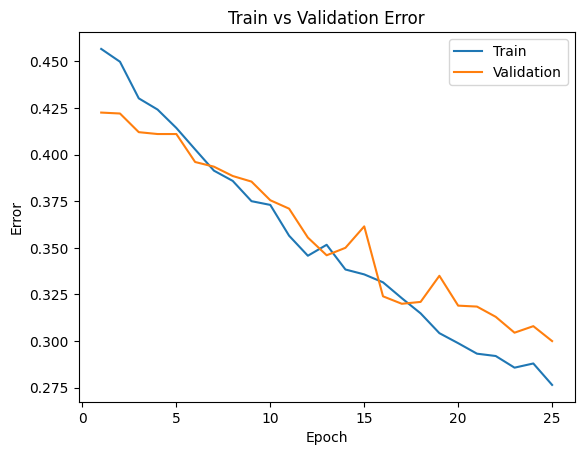

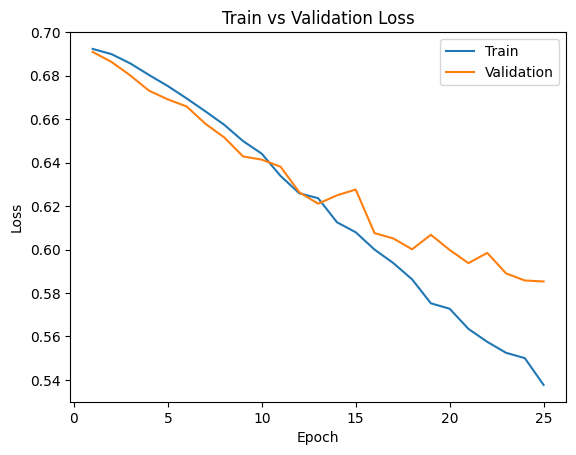

In [ ]:
model_path = get_model_name("large", batch_size=128, learning_rate=0.007, epoch=24)
plot_training_curve(model_path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
train_net(net, 128, 0.01, 30)
model_path = get_model_name("large", batch_size=128, learning_rate=0.01, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.49475, Train loss: 0.6930217638848319 |Validation err: 0.4785, Validation loss: 0.691717941313982
Epoch 2: Train err: 0.442625, Train loss: 0.6902927992835878 |Validation err: 0.4205, Validation loss: 0.6878543831408024
Epoch 3: Train err: 0.4385, Train loss: 0.6854409717378163 |Validation err: 0.414, Validation loss: 0.6805256269872189
Epoch 4: Train err: 0.42775, Train loss: 0.6785378777791583 |Validation err: 0.4175, Validation loss: 0.6720023937523365
Epoch 5: Train err: 0.415, Train loss: 0.670867815850273 |Validation err: 0.3975, Validation loss: 0.663852758705616
Epoch 6: Train err: 0.395875, Train loss: 0.6599501087552025 |Validation err: 0.391, Validation loss: 0.6539640463888645
Epoch 7: Train err: 0.383375, Train loss: 0.6531939459225488 |Validation err: 0.3805, Validation loss: 0.6486352495849133
Epoch 8: Train err: 0.36525, Train loss: 0.6382708587343731 |Validation err: 0.369

<ipython-input-23-9d883085bf6b>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

* default Validation err: 0.303, Validation loss: 0.67

* Hyperparameter Search (c) Validation err: 0.3, Validation loss: 0.59

* Hyperparameter Search (a); also my choice Validation err: 0.291, Validation loss: 0.583

The choice seems to be smaller than the result from the another choices





### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=64)

criterion = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(net, test_loader, criterion)
print("test classification error:", test_err)
print("test classification loss:", test_loss)

Files already downloaded and verified
Files already downloaded and verified
test classification error: 0.2995
test classification loss: 0.5620032520964742


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

The test classification error is higher than the validation error. This is because, we are training the data in training set, and alidation on the validation set, making the model a good fir for these two sets. So, the validation error makes sense to be smaller than the test error since the testing dataset is unseen by the model before.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

 Because the test data are not within  the training and validation data. They are unseen by the model, so they are "unbiased" and simulate how the model actually perform. However, if we use the test data too much, they will affect the model and no longer truely indicate the accuracy of the model.


### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

The 2 layer ANN architecture did not perform as well as the CNN architecture. No matter what hyperparameters I tried, I was not able to get the validation error lower than CNN without heavily overfitting the training set. The error rate is 0.363, while the CNN architecture has a far lower error rate (e.g. 0.291).

In [ ]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.name = "ANN"
        self.layer1 = nn.Linear(3 * 32 * 32, 32)
        self.layer2 = nn.Linear(32, 1)
    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = x.squeeze(1)
        return x
ANN_net = ANN()
train_net(ANN_net, batch_size=512, learning_rate=0.005, num_epochs=40)
ANN_model_path = get_model_name("ANN", batch_size=512, learning_rate=0.005, epoch=39)
plot_training_curve(ANN_model_path)

In [ ]:
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=512)

criterion = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(ANN_net, test_loader, criterion)

print("test classification error:", test_err)
print("test classification loss:", test_loss)

Files already downloaded and verified
Files already downloaded and verified
test classification error: 0.363
test classification loss: 0.6392948627471924


In [ ]:
from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor
from torchvision.ops import box_convert
import torch

# RCNN model class from the previous implementation
class RCNN(nn.Module):
    def __init__(self, num_classes):
        super(RCNN, self).__init__()
        resnet = resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-2])
        self.roi_pool = roi_pool
        self.classifier = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes)
        )
        self.bbox_regressor = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 4)
        )

    def forward(self, images, rois):
        feature_maps = self.feature_extractor(images)
        pooled_features = self.roi_pool(feature_maps, rois, output_size=(7, 7))
        pooled_features = pooled_features.view(pooled_features.size(0), -1)
        class_scores = self.classifier(pooled_features)
        bbox_deltas = self.bbox_regressor(pooled_features)
        return class_scores, bbox_deltas


# Load COCO dataset
images_path = "/path/to/coco/images/train2017"
annotations_path = "/path/to/coco/annotations/instances_train2017.json"
coco_dataset = CocoDetection(root=images_path, annFile=annotations_path, transform=ToTensor())

# Instantiate RCNN model
num_classes = 91  # COCO has 80 classes + 1 background class + 10 reserved classes
rcnn = RCNN(num_classes)

# Process a sample from the dataset
image, targets = coco_dataset[0]
image = image.unsqueeze(0)  # Add batch dimension

# Extract bounding boxes and labels from annotations
bounding_boxes = []
labels = []

for obj in targets:
    bounding_boxes.append(obj['bbox'])  # COCO uses [x_min, y_min, width, height]
    labels.append(obj['category_id'])

bounding_boxes = torch.tensor(bounding_boxes, dtype=torch.float)
labels = torch.tensor(labels, dtype=torch.long)

# Convert bounding boxes to RCNN's required format [x_min, y_min, x_max, y_max]
bounding_boxes = box_convert(bounding_boxes, in_fmt="xywh", out_fmt="xyxy")

# Create RoIs tensor for RCNN input ([batch_idx, x_min, y_min, x_max, y_max])
batch_size = image.shape[0]
rois = torch.cat([torch.zeros(bounding_boxes.size(0), 1), bounding_boxes], dim=1)  # Add batch_idx = 0
rois[:, 0] = 0  # Batch index for all boxes is 0 (single image)

# Forward pass through RCNN
class_scores, bbox_deltas = rcnn(image, rois)

# Post-processing: Convert bbox_deltas to refined bounding boxes
refined_boxes = bounding_boxes + bbox_deltas  # Add deltas to original boxes

# Display results
print("Class Scores (per RoI):", class_scores)
print("Refined Bounding Boxes:", refined_boxes)


loading annotations into memory...


FileNotFoundError: [Errno 2] No such file or directory: '/path/to/coco/annotations/instances_train2017.json'